# Prova 2

import dos módulos básicos

In [271]:
# always yielding a real result, even dividing two integers
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import datetime as dt
from dateutil.relativedelta import relativedelta

# plot inline
%matplotlib inline

Carregando dados de feriados: cdi e bmf.
Fonte: [anbima](http://www.anbima.com.br/feriados/feriados.asp)

In [2]:
feriado_arq = 'feriados.xlsx'
feriado_cdi = pd.read_excel(feriado_arq,'cdi')
feriado_bmf = pd.read_excel(feriado_arq,'bmf')

Carregando dados de mercado

In [3]:
mkt_series_arq = 'BBergValues.xlsx'
usdbrl = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="A:E")
ptax = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="G:H")
ibov = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="J:M")
di1f21 = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="O:S")
cdi = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="U:V")
cds5y = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="X:AB")
vol1m_off = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="AD:AH")
vol3m_off = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="AJ:AN")
vol12m_off = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="AP:AT")
swpprecdi1m = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="AV:AZ")
swpprecdi3m = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="BB:BF")
swpprecdi12m = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="BH:BL")
fwd1m_on = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="BN:BR")
fwd3m_on = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="BT:BX")
fwd12m_on = pd.read_excel(mkt_series_arq,'Sheet1',skiprows=1,index_col=0,parse_cols="BZ:CD")



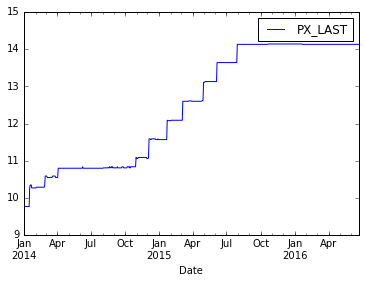

In [4]:
cdi.plot()

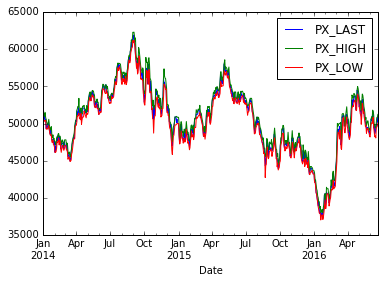

In [5]:
ibov.plot()

## Questão 1
___

Como estimar o risco dos portfolios do fundo a partir das séries de preços? Aponte as diferenças entre como
estimar o risco entre os diferentes tipos de séries. Assuma que esse cálculo está sendo feito em 31-Mar-2016.

## Questão 2
___

Um trader olhou o gráfico abaixo e pensou em uma estratégia.

![alt text](images/Capture.png "BRAZIL CDS USD SR 5Y D1")

**a)** Qual a estratégia que você acha que ele pensou?

**b)** Faz sentido? Qual a proporção dos ativos? Ela é fixa?

**c)** Se ele tivesse entrado no trade em 13-Abr-2016, qual teria sido o máximo drawdown (perda) dele no
período entre 13-Abr-2016 e 22-Jun-2016? Assuma notional de BRL 1MM.

**d)** A estimativa de risco que você teria feito teria estimado corretamente esse resultado?

**e)** Acrescente Ibovespa como uma estratégia (não esqueça do funding!); você faria algum novo trade?

## Questão 3
___

Em 30-Jun-2015 vários traders compraram opções de compra de USD (venda de BRL) ATMF para diferentes
prazos. Use os dados anexos, interpolação linear para spot e forwards, e a interpolação adequada para vols
ATMF (vol forward constante, variância efetiva é a soma das variâncias efetivas) para estimar os resultados
finais e perdas máximas de cada um dos traders.

Definindo a função BS para ser utilizada na precificação das opções

In [413]:
def bsv(phi,F,K,discount,vol,t):
    if(t>0):
        # calculate d1 and d2
        sigma_rt = vol*np.sqrt(t)
        d1=(np.log(F/K)+(vol**2/2)*t)/(sigma_rt)
        d2=d1-sigma_rt

        # calculate N(d1) and N(d2)
        Nd1=st.norm.cdf(phi*d1)
        Nd2=st.norm.cdf(phi*d2)
        delta=phi*Nd1*discount
        premium=phi*(F*Nd1-K*Nd2)*discount
    else:
        delta=0
        premium=max(phi*(F-K),0)
        
    return [premium,delta]

**a)** O primeiro comprou uma opção de 1m e carregou sem hedge até o final.

O strike da opção ATMF de 1 mês em 30-Jun-2015 vale:

In [414]:
fwd1m_on['PX_LAST']['2015-06-30']

3.1364000000000001

In [415]:
call=1
t=30/365
S=ptax['PX_ASK']['2015-06-30']
K=fwd1m_on['PX_LAST']['2015-06-30']
r=(1+swpprecdi1m['PX_LAST']['2015-06-30']/100)**(-t)
vol=vol1m_off['PX_LAST']['2015-06-30']/100
[K,S,r,vol,t,swpprecdi1m['PX_LAST']['2015-06-30']/100,bsv(call,K,K,r,vol,t)]

[3.1364000000000001,
 3.1025999999999998,
 0.98952100449935765,
 0.16111999999999999,
 0.0821917808219178,
 0.136743,
 [0.057186243352910809, 0.50387704404168732]]

In [416]:
start=dt.datetime.strptime('2015-06-30','%Y-%m-%d')
tenor=relativedelta(months=1)

In [417]:
end=start+tenor

In [418]:
s=pd.Series(ptax['PX_ASK'][start:end])
s.index[0]+tenor

Timestamp('2015-07-30 00:00:00')

In [419]:
def interpolaVol(dt0,v0,dt1,v1,dt):
    vv0=v0**2
    vv1=v1**2
    d0=dt0.toordinal()
    d1=dt1.toordinal()
    d=dt.toordinal()
    
    vv=((1/(d1-d0))*(vv1*d1*(d-d0)+vv0*d0*(d1-d)))/d
    return np.sqrt(vv)

In [420]:
s=pd.Series(ptax['PX_ASK'][start:end])
df=pd.DataFrame(s.index)
df['tenor']=[i+tenor for i in s.index]
df['t']=[(end.toordinal()-i.toordinal())/365 for i in df['Date']]
df['fwd']=fwd1m_on['PX_LAST'][start:end].values
df['strike']=df['fwd'][0]
df['vol1m']=vol1m_off['PX_LAST'][start:end].values/100
df['vol']=[interpolaVol(df['Date'][i],df['vol1m'][i],df['tenor'][i],df['vol1m'][i],end) for i in df['Date'].index]
df['cdi']=cdi['PX_LAST'][start:end].values/100
df['pre1m']=swpprecdi1m['PX_LAST'][start:end].values/100
#interpolate
df['discount']=[df['cdi'][i]+(df['pre1m'][i]-df['cdi'][i])*((end-df['Date'][i])/(df['tenor'][i]-df['Date'][i])) for i in df['Date'].index]
#calculate discount factor
df['discount']=(1+df['discount'])**[-(end.toordinal()-i.toordinal())/365 for i in df['Date']]

df['bsv']=[bsv(call,df['fwd'][i],df['strike'][i],df['discount'][i],df['vol'][i],df['t'][i]) for i in df['Date'].index]

df


,Date,tenor,t,fwd,strike,vol1m,vol,cdi,pre1m,discount,bsv
0,2015-06-30,2015-07-30,0.082192,3.1364,3.1364,0.16112,0.16112,0.1364,0.136743,0.989521,"[0.0571862433529, 0.503877044042]"
1,2015-07-01,2015-08-01,0.079452,3.1824,3.1364,0.16195,0.16195,0.1364,0.136777,0.989868,"[0.0825880596278, 0.627319906991]"
2,2015-07-02,2015-08-02,0.076712,3.1300,3.1364,0.15243,0.15243,0.1364,0.136766,0.990217,"[0.0491440117143, 0.484335803973]"
3,2015-07-03,2015-08-03,0.073973,3.1680,3.1364,0.15010,0.15010,0.1364,0.136767,0.990565,"[0.0680264363608, 0.59916363828]"
4,2015-07-06,2015-08-06,0.065753,3.1706,3.1364,0.14202,0.14202,0.1364,0.136944,0.991603,"[0.0643840655188, 0.618763677542]"
5,2015-07-07,2015-08-07,0.063014,3.2196,3.1364,0.15350,0.15350,0.1364,0.137075,0.991948,"[0.100493691663, 0.751539755502]"
6,2015-07-08,2015-08-08,0.060274,3.2694,3.1364,0.15923,0.15923,0.1364,0.137130,0.992295,"[0.141151197314, 0.853729145114]"
7,2015-07-09,2015-08-09,0.057534,3.2701,3.1364,0.15930,0.15930,0.1364,0.137130,0.992646,"[0.141175122326, 0.860472513427]"
8,2015-07-10,2015-08-10,0.054795,3.1916,3.1364,0.15640,0.15640,0.1364,0.137198,0.992994,"[0.0784050999387, 0.684816768601]"
9,2015-07-13,2015-08-13,0.046575,3.1683,3.1364,0.14915,0.14915,0.1364,0.137439,0.994039,"[0.0580644353631, 0.625727955721]"


In [375]:
[(end.toordinal()-i.toordinal())/365 for i in df['Date']]

[0.0821917808219178,
 0.07945205479452055,
 0.07671232876712329,
 0.07397260273972603,
 0.06575342465753424,
 0.06301369863013699,
 0.06027397260273973,
 0.057534246575342465,
 0.0547945205479452,
 0.04657534246575343,
 0.043835616438356165,
 0.0410958904109589,
 0.038356164383561646,
 0.03561643835616438,
 0.0273972602739726,
 0.024657534246575342,
 0.021917808219178082,
 0.019178082191780823,
 0.01643835616438356,
 0.00821917808219178,
 0.005479452054794521,
 0.0027397260273972603,
 0.0]

In [346]:
[df['cdi'][i]+(df['pre1m'][i]-df['cdi'][i])*((end-df['Date'][i])/(df['tenor'][i]-df['Date'][i])) for i in df['Date'].index]

[0.136743,
 0.13675267741935485,
 0.13673058064516128,
 0.13671964516129032,
 0.1368211612903226,
 0.1369008064516129,
 0.13691806451612903,
 0.13689451612903225,
 0.13691483870967741,
 0.13696977419354839,
 0.13705548387096772,
 0.13705419354838708,
 0.13693290322580645,
 0.13697325806451613,
 0.13690032258064516,
 0.13689412903225806,
 0.13691251612903227,
 0.13694216129032258,
 0.13704954838709676,
 0.13679522580645162,
 0.13668154838709676,
 0.13654545161290321,
 0.14130000000000001]

In [314]:
def portf1m(start):
    term=relativedelta(months=1)
    end=start+tenor
    s=pd.Series(ptax['PX_ASK'][start:end])
    s=pd.Series(ptax['PX_ASK'][start:end])
    df=pd.DataFrame(s.index)
    df['1m']=[i+tenor for i in s.index]
    df['fwd']=fwd1m_on['PX_LAST'][start:end].values
    df['vol']=vol1m_off['PX_LAST'][start:end].values/100
    df['discount']=swpprecdi1m['PX_LAST'][start:end].values/100
    return df

In [317]:
portf1m(dt.datetime(2015,6,30))

,Date,1m,fwd,vol,discount
0,2015-06-30,2015-07-30,3.1364,0.16112,0.1268
1,2015-07-01,2015-08-01,3.1824,0.16195,0.1275
2,2015-07-02,2015-08-02,3.1300,0.15243,0.1259
3,2015-07-03,2015-08-03,3.1680,0.15010,0.1258
4,2015-07-06,2015-08-06,3.1706,0.14202,0.1266
5,2015-07-07,2015-08-07,3.2196,0.15350,0.1263
6,2015-07-08,2015-08-08,3.2694,0.15923,0.1267
7,2015-07-09,2015-08-09,3.2701,0.15930,0.1267
8,2015-07-10,2015-08-10,3.1916,0.15640,0.1262
9,2015-07-13,2015-08-13,3.1683,0.14915,0.1260


**b)**  O segundo comprou uma opção de 1m e fez o delta hedge até o final.

## Questão 4
___

**a)** Monte Carlo

**b)** PDE

implementação sugerida

In [ ]:
def grid(N,T,Nj,S,dx,vol,r,q,K,output='V'):
    dt = T / N
    if dx < vol * np.sqrt(3 * dt):
        print('Convergence error')
    mu = -(0.5)*(r-q)*vol**2
    emdx = np.exp(-dx)
    ppu = 0.5 * dt * ((vol / dx) ** 2 + mu / dx)
    ppm = 1.0-dt * (vol / dx) ** 2-r * dt
    ppd = 0.5 * dt * ((vol / dx) ** 2-mu / dx)
    St = np.full(2 * Nj + 1,0.)
    St[0] = S * np.exp(Nj * dx)
    for j in np.arange(1,2 * Nj + 1):
        St[j] = St[j-1]*emdx
    Ct = np.full((2 * Nj + 1,N + 1),np.nan)
    for j in np.arange(0,2 * Nj + 1):
        Ct[j,N] = np.max([St[j]-K,0])
    for i in np.arange(N-1,-1,-1):
        for k in np.arange(N-i,2 * Nj + 1-(N-i)):
            Ct[k,i] = ppu * Ct[k-1,i + 1]+ ppm * Ct[k,i + 1] + ppd * Ct[k + 1,i + 1]
        #Boundary
    #Boundary
    if output == 'G':
        return Ct
    else:
        return Ct[Nj,0]
